# Uploading data

In [1]:
from sklearn.experimental import enable_iterative_imputer

In [2]:
import pandas as pd
from statsmodels.imputation import mice
from statsmodels.imputation.mice import MICEData
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

In [3]:
df = pd.read_csv('Spotify_data.csv')

# Quick look at data

In [4]:
df

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,20-35,Female,More than 2 years,"Smartphone, Computer or laptop, Wearable devices",Free (ad-supported),Yes,Student Plan-Rs 59/month,Music,Pop,Morning,"Uplifting and motivational, Sadness or melancholy",While Traveling,recommendations,5,Rarely,Lifestyle and Health,Conversational,Both,Shorter,Ok
516,20-35,Female,More than 2 years,"Smartphone, Computer or laptop",Free (ad-supported),Yes,Student Plan-Rs 59/month,Music,Pop,Night,"Relaxation and stress relief, Uplifting and mo...","While Traveling, Workout session, leisure time",Others,2,Rarely,Comedy,Story telling,Both,Shorter,Ok
517,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,Student Plan-Rs 59/month,Music,Pop,Night,Relaxation and stress relief,leisure time,recommendations,3,Never,NaN,Story telling,Both,Shorter,Ok
518,20-35,Female,6 months to 1 year,Smartphone,Premium (paid subscription),Yes,Individual Plan- Rs 119/ month,Music,Melody,Night,"Relaxation and stress relief, Uplifting and mo...","Workout session, leisure time","recommendations, Others",2,Several times a week,Comedy,Conversational,Both,Longer,Satisfied


In [5]:
df.describe()

,music_recc_rating
count,520.000000
mean,3.503846
std,0.979552
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    object
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    object
 5   premium_sub_willingness      520 non-null    object
 6   preffered_premium_plan       312 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

# Feature engineering

In [7]:
# Making a copy of df to use for descriptive analysis later

#df_descriptive = df.copy()

In [8]:
df['spotify_usage_period'].replace(['More than 2 years', '6 months to 1 year', '1 year to 2 years',
       'Less than 6 months'], [4, 2, 3, 1], inplace = True)

/tmp/ipykernel_6807/2194857433.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['spotify_usage_period'].replace(['More than 2 years', '6 months to 1 year', '1 year to 2 years',
/tmp/ipykernel_6807/2194857433.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['spotify_usage_period'].replace

In [9]:
for index in df.index:
    if ((df.at[index, 'spotify_subscription_plan'] != 'Premium (paid subscription)') and 
        (df.at[index, 'premium_sub_willingness'] != 'Yes')) and (pd.isnull(df.at[index, 'preffered_premium_plan'])):
        df.at[index, 'preffered_premium_plan'] = "None"

In [10]:
df['spotify_subscription_plan'].value_counts()

spotify_subscription_plan
Free (ad-supported)            424
Premium (paid subscription)     96
Name: count, dtype: int64

In [11]:
df['spotify_subscription_plan'].replace(['Free (ad-supported)', 'Premium (paid subscription)'], [0, 1], inplace = True)

/tmp/ipykernel_6807/3366362625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['spotify_subscription_plan'].replace(['Free (ad-supported)', 'Premium (paid subscription)'], [0, 1], inplace = True)
/tmp/ipykernel_6807/3366362625.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['spotify_su

In [12]:
df['premium_sub_willingness'].value_counts()

premium_sub_willingness
No     334
Yes    186
Name: count, dtype: int64

In [13]:
df['premium_sub_willingness'].replace(['No', 'Yes'], [0, 1], inplace = True)

/tmp/ipykernel_6807/3616318502.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['premium_sub_willingness'].replace(['No', 'Yes'], [0, 1], inplace = True)
/tmp/ipykernel_6807/3616318502.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['premium_sub_willingness'].replace(['No', 'Yes'], [0, 

In [14]:
df['preffered_pod_duration'].fillna(df['preffered_pod_duration'].mode(), inplace=True)

/tmp/ipykernel_6807/1028543461.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preffered_pod_duration'].fillna(df['preffered_pod_duration'].mode(), inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    int64 
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    int64 
 5   premium_sub_willingness      520 non-null    int64 
 6   preffered_premium_plan       508 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

In [16]:
df['preffered_premium_plan'].value_counts()

preffered_premium_plan
None                              196
Individual Plan- Rs 119/ month     95
Student Plan-Rs 59/month           94
Duo plan- Rs 149/month             84
Family Plan-Rs 179/month           39
Name: count, dtype: int64

In [17]:
df['preffered_premium_plan'].fillna("no_data", inplace = True)

/tmp/ipykernel_6807/3550302017.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preffered_premium_plan'].fillna("no_data", inplace = True)


In [18]:
df['preffered_premium_plan'].value_counts()

preffered_premium_plan
None                              196
Individual Plan- Rs 119/ month     95
Student Plan-Rs 59/month           94
Duo plan- Rs 149/month             84
Family Plan-Rs 179/month           39
no_data                            12
Name: count, dtype: int64

In [19]:
df['preffered_premium_plan'].unique()

array(['Family Plan-Rs 179/month', 'Individual Plan- Rs 119/ month',
       'Student Plan-Rs 59/month', 'None', 'no_data',
       'Duo plan- Rs 149/month'], dtype=object)

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [21]:
imputed_col = 'preffered_premium_plan'
impute_col_encoded = 'preffered_premium_plan_no'

In [22]:
le.fit(df.loc[:,imputed_col]);

In [23]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'Duo plan- Rs 149/month': np.int64(0),
 'Family Plan-Rs 179/month': np.int64(1),
 'Individual Plan- Rs 119/ month': np.int64(2),
 'None': np.int64(3),
 'Student Plan-Rs 59/month': np.int64(4),
 'no_data': np.int64(5)}

In [24]:
df[impute_col_encoded] = le.transform(df[imputed_col])

In [25]:
df[impute_col_encoded] = df[impute_col_encoded].map(lambda x: np.nan if x == 5 else x)

In [26]:
imputer = IterativeImputer(random_state = 100)

In [27]:
df_train = df.loc[:, ['spotify_subscription_plan', impute_col_encoded]]

In [28]:
imputer.fit(df_train);

In [29]:
df_imputed = imputer.transform(df_train)

In [30]:
df_imputed[:10]

array([[0., 1.],
       [0., 2.],
       [0., 4.],
       [0., 3.],
       [0., 3.],
       [0., 3.],
       [0., 3.],
       [0., 3.],
       [0., 2.],
       [0., 3.]])

In [31]:
df_imputed[:,1].round()

array([1., 2., 4., 3., 3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 2.,
       3., 3., 2., 3., 2., 3., 2., 1., 3., 4., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 2., 3., 3., 3., 3., 4., 3., 3., 3., 3., 4., 3., 2., 3.,
       3., 2., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 2., 2.,
       3., 2., 3., 3., 3., 3., 1., 4., 0., 2., 2., 0., 3., 0., 3., 2., 3.,
       0., 3., 3., 2., 3., 2., 2., 3., 3., 3., 3., 3., 3., 2., 2., 2., 4.,
       3., 3., 3., 3., 3., 3., 3., 0., 3., 3., 3., 3., 3., 3., 1., 1., 3.,
       3., 3., 0., 3., 3., 2., 3., 3., 4., 3., 3., 3., 3., 3., 3., 4., 3.,
       2., 3., 3., 3., 1., 3., 3., 2., 3., 3., 1., 3., 3., 3., 3., 0., 4.,
       3., 1., 3., 2., 3., 3., 3., 3., 2., 3., 3., 3., 0., 1., 0., 0., 0.,
       3., 3., 1., 0., 1., 3., 4., 0., 0., 0., 1., 1., 3., 1., 3., 3., 1.,
       3., 3., 3., 3., 3., 3., 3., 3., 0., 3., 3., 4., 3., 3., 3., 3., 1.,
       4., 3., 3., 3., 3., 3., 3., 2., 3., 4., 3., 3., 3., 3., 3., 2., 4.,
       4., 4., 4., 3., 2.

In [32]:
df.loc[:, [impute_col_encoded]] = df_imputed[:, 1].round()

In [33]:
preffered_premium_plan_imputed = list(le.inverse_transform(df[impute_col_encoded].round().astype('int')))

In [34]:
df['preffered_premium_plan'] = preffered_premium_plan_imputed

In [35]:
df['preffered_premium_plan'].value_counts()

preffered_premium_plan
None                              200
Individual Plan- Rs 119/ month     95
Student Plan-Rs 59/month           94
Duo plan- Rs 149/month             84
Family Plan-Rs 179/month           47
Name: count, dtype: int64

In [36]:
df['spotify_subscription_plan'].value_counts()

spotify_subscription_plan
0    424
1     96
Name: count, dtype: int64

In [37]:
df['premium_sub_willingness'].value_counts()

premium_sub_willingness
0    334
1    186
Name: count, dtype: int64

In [38]:
df.drop('preffered_premium_plan_no', axis = 1, inplace = True)

In [39]:
df['preffered_pod_duration'].fillna(df['preffered_pod_duration'].mode()[0], inplace=True)

/tmp/ipykernel_6807/1118908023.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preffered_pod_duration'].fillna(df['preffered_pod_duration'].mode()[0], inplace=True)


In [40]:
df['preffered_pod_format'].ffill(inplace = True)

/tmp/ipykernel_6807/1996653878.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preffered_pod_format'].ffill(inplace = True)


In [41]:
df.fillna('miss_data', inplace = True)

In [42]:
df['preffered_pod_duration'].value_counts()

preffered_pod_duration
Shorter    320
Both       117
Longer      83
Name: count, dtype: int64

In [43]:
df['fav_pod_genre'].value_counts()

fav_pod_genre
miss_data                                           148
Comedy                                              107
Lifestyle and Health                                102
Health and Fitness                                   78
Sports                                               51
Food and cooking                                     20
Business                                              1
Everything                                            1
Informative stuff                                     1
Dance and Relevant cases                              1
Technology                                            1
General knowledge                                     1
Spiritual and devotional                              1
Finance related and current affairs                   1
Murder Mystery                                        1
Political, informative, topics that interests me      1
Novels                                                1
Self help                         

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    int64 
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    int64 
 5   premium_sub_willingness      520 non-null    int64 
 6   preffered_premium_plan       520 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

In [45]:
# For the future analysis

df_descriptive = df.copy()

In [46]:
df['preffered_premium_plan'].value_counts()

preffered_premium_plan
None                              200
Individual Plan- Rs 119/ month     95
Student Plan-Rs 59/month           94
Duo plan- Rs 149/month             84
Family Plan-Rs 179/month           47
Name: count, dtype: int64

In [47]:
df['Age'].unique()

array(['20-35', '12-20', '35-60', '6-12', '60+'], dtype=object)

In [48]:
df['Age'].replace(['20-35', '12-20', '35-60', '6-12', '60+'], [3, 2, 4, 1, 5], inplace = True)

/tmp/ipykernel_6807/643817562.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].replace(['20-35', '12-20', '35-60', '6-12', '60+'], [3, 2, 4, 1, 5], inplace = True)
/tmp/ipykernel_6807/643817562.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Age'].replace(['20-35', '12-20', '35-

In [49]:
df['Gender'] = df['Gender'].str.lower()

In [50]:
df['Gender'].value_counts()

Gender
female    391
male      114
others     15
Name: count, dtype: int64

In [51]:
df['spotify_listening_device'].value_counts()

spotify_listening_device
Smartphone                                                                              300
Computer or laptop                                                                       54
Smartphone, Computer or laptop                                                           48
Smart speakers or voice assistants                                                       43
Computer or laptop, Smart speakers or voice assistants                                   14
Smartphone, Smart speakers or voice assistants                                           10
Smartphone, Wearable devices                                                              8
Smartphone, Computer or laptop, Smart speakers or voice assistants, Wearable devices      8
Wearable devices                                                                          8
Smartphone, Computer or laptop, Smart speakers or voice assistants                        7
Computer or laptop, Wearable devices                   

In [52]:
df.drop('spotify_listening_device', axis = 1,  inplace = True)

In [53]:
# df.drop(labels = 'preffered_premium_plan', axis = 1,  inplace = True)

In [54]:
df['preffered_premium_plan'].replace(['None', 'Student Plan-Rs 59/month', 'Individual Plan- Rs 119/ month', 'Duo plan- Rs 149/month', 'Family Plan-Rs 179/month'], [1, 2, 3, 4, 5], inplace = True)

/tmp/ipykernel_6807/2226825674.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preffered_premium_plan'].replace(['None', 'Student Plan-Rs 59/month', 'Individual Plan- Rs 119/ month', 'Duo plan- Rs 149/month', 'Family Plan-Rs 179/month'], [1, 2, 3, 4, 5], inplace = True)
/tmp/ipykernel_6807/2226825674.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior

In [55]:
df['preferred_listening_content'].value_counts()

preferred_listening_content
Music      410
Podcast    110
Name: count, dtype: int64

In [56]:
df['preferred_listening_content'].replace(['Music', 'Podcast'], [0, 1], inplace = True)

/tmp/ipykernel_6807/3124389116.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preferred_listening_content'].replace(['Music', 'Podcast'], [0, 1], inplace = True)
/tmp/ipykernel_6807/3124389116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['preferred_listening_content'].replace(['Mu

In [57]:
df['fav_music_genre'].value_counts()

fav_music_genre
Melody                       259
classical                     87
Pop                           85
Rap                           55
Electronic/Dance              16
All                            6
Rock                           4
Kpop                           4
Classical & melody, dance      2
Old songs                      1
trending songs random          1
Name: count, dtype: int64

In [58]:
fav_music = ['Melody', 'classical', 'Pop', 'Rap']

In [59]:
df['fav_music_genre'] = df['fav_music_genre'].apply(lambda x: 'other' if x not in fav_music else x)

In [60]:
df['fav_music_genre'] = df['fav_music_genre'].str.lower()

In [61]:
df['fav_music_genre'].value_counts()

fav_music_genre
melody       259
classical     87
pop           85
rap           55
other         34
Name: count, dtype: int64

In [62]:
df['music_time_slot'] = df['music_time_slot'].str.lower()

In [63]:
df['music_time_slot'].value_counts()

music_time_slot
night        312
afternoon    117
morning       91
Name: count, dtype: int64

In [64]:
df['music_Influencial_mood'].value_counts()

music_Influencial_mood
Relaxation and stress relief                                                                                     195
Uplifting and motivational                                                                                        67
Sadness or melancholy                                                                                             55
Relaxation and stress relief, Uplifting and motivational                                                          44
Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy, Social gatherings or parties     35
Relaxation and stress relief, Sadness or melancholy                                                               33
Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy                                   22
Social gatherings or parties                                                                                      16
Relaxation and stress relief, Uplifting a

In [65]:
music_mood = ['Relaxation and stress relief', 'Uplifting and motivational', 'Sadness or melancholy', 'Social gatherings or parties']

In [66]:
df['music_Influencial_mood'] = df['music_Influencial_mood'].apply(lambda x: 'mix' if x not in music_mood else x)

In [67]:
df['music_Influencial_mood'].replace(['Relaxation and stress relief', 'Uplifting and motivational', 'Sadness or melancholy', 'Social gatherings or parties'] , ['relaxation', 'motivational', 'sad', 'social'], inplace = True)

/tmp/ipykernel_6807/572618279.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['music_Influencial_mood'].replace(['Relaxation and stress relief', 'Uplifting and motivational', 'Sadness or melancholy', 'Social gatherings or parties'] , ['relaxation', 'motivational', 'sad', 'social'], inplace = True)


In [68]:
df['music_Influencial_mood'].value_counts()

music_Influencial_mood
relaxation      195
mix             187
motivational     67
sad              55
social           16
Name: count, dtype: int64

In [69]:
df['music_lis_frequency'].value_counts()

music_lis_frequency
While Traveling                                                                111
leisure time                                                                    87
While Traveling, leisure time                                                   65
While Traveling, Workout session, leisure time                                  48
Workout session                                                                 33
Study Hours                                                                     19
Office hours                                                                    16
While Traveling, Workout session                                                16
Office hours, While Traveling, leisure time                                     12
Office hours, While Traveling                                                   12
Office hours, While Traveling, Workout session                                  10
Study Hours, While Traveling, leisure time                         

In [70]:
frequency_list_full = ['While Traveling', 'leisure time', 'Workout session', 'Study Hours', 'Office hours', 'Social gatherings ', 'Random ']

In [71]:
frequency_list_shorted = ['While Traveling', 'leisure time', 'Workout session', 'Study Hours', 'Office hours', 'mix']

In [72]:
df['music_lis_frequency'] = df['music_lis_frequency'].apply(lambda x: 'mix' if x not in frequency_list_full else x)

In [73]:
df['music_lis_frequency'].value_counts()

music_lis_frequency
mix                   252
While Traveling       111
leisure time           87
Workout session        33
Study Hours            19
Office hours           16
Social gatherings       1
Random                  1
Name: count, dtype: int64

In [74]:
df['music_lis_frequency'] = df['music_lis_frequency'].apply(lambda x: 'other' if x not in frequency_list_shorted else x)

In [75]:
df['music_lis_frequency'].replace(['While Traveling', 'leisure time', 'Workout session', 'Study Hours', 'Office hours'] , ['traveling', 'leisure', 'workout', 'study', 'office'], inplace = True)

/tmp/ipykernel_6807/4148197643.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['music_lis_frequency'].replace(['While Traveling', 'leisure time', 'Workout session', 'Study Hours', 'Office hours'] , ['traveling', 'leisure', 'workout', 'study', 'office'], inplace = True)


In [76]:
df['music_lis_frequency'].value_counts()

music_lis_frequency
mix          252
traveling    111
leisure       87
workout       33
study         19
office        16
other          2
Name: count, dtype: int64

In [77]:
df['music_expl_method'].value_counts()

music_expl_method
recommendations                              113
Playlists                                    112
recommendations, Playlists                    86
Others                                        55
Radio                                         51
Playlists, Radio                              18
recommendations, Playlists, Others            18
recommendations, Others                       15
recommendations, Playlists, Radio             13
Playlists, Others                              9
Radio, Others                                  7
recommendations, Radio                         6
Playlists, Radio, Others                       6
recommendations, Radio, Others                 4
recommendations, Playlists, Radio, Others      2
recommendations,Others, Social media           1
Others, Social media                           1
Others, Friends                                1
recommendations, Others, Social media          1
Others, Search                                 1
Na

In [78]:
music_method = ['recommendations', 'Playlists', 'Others', 'Radio']

In [79]:
df['music_expl_method'] = df['music_expl_method'].apply(lambda x: 'mix' if x not in music_method else x)

In [80]:
df['music_expl_method'] = df['music_expl_method'].str.lower()

In [81]:
df['music_expl_method'].value_counts()

music_expl_method
mix                189
recommendations    113
playlists          112
others              55
radio               51
Name: count, dtype: int64

In [82]:
df['pod_lis_frequency'].value_counts()

pod_lis_frequency
Rarely                  201
Never                   130
Once a week              91
Several times a week     78
Daily                    20
Name: count, dtype: int64

In [83]:
df['pod_lis_frequency'].replace(['Never', 'Rarely', 'Once a week', 'Several times a week', 'Daily'], [1 ,2 ,3, 4, 5], inplace = True)

/tmp/ipykernel_6807/3396764345.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pod_lis_frequency'].replace(['Never', 'Rarely', 'Once a week', 'Several times a week', 'Daily'], [1 ,2 ,3, 4, 5], inplace = True)
/tmp/ipykernel_6807/3396764345.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

In [84]:
df['fav_pod_genre'].value_counts()

fav_pod_genre
miss_data                                           148
Comedy                                              107
Lifestyle and Health                                102
Health and Fitness                                   78
Sports                                               51
Food and cooking                                     20
Business                                              1
Everything                                            1
Informative stuff                                     1
Dance and Relevant cases                              1
Technology                                            1
General knowledge                                     1
Spiritual and devotional                              1
Finance related and current affairs                   1
Murder Mystery                                        1
Political, informative, topics that interests me      1
Novels                                                1
Self help                         

In [85]:
fav_genre = ['None', 'Comedy', 'Lifestyle and Health', 'Health and Fitness', 'Sports', 'miss_data']
fav_genre_short = ['None', 'Comedy', 'other', 'miss_data']

def categorize_genre(x):
    if x not in fav_genre:
        return 'other'
    elif x not in fav_genre_short:
        return 'fit'
    else:
        return x

df['fav_pod_genre'] = df['fav_pod_genre'].apply(categorize_genre)


In [86]:
df['fav_pod_genre'] = df['fav_pod_genre'].str.lower()

In [87]:
df['fav_pod_genre'] = df['fav_pod_genre'].astype(str)

In [88]:
df['fav_pod_genre'].value_counts()

fav_pod_genre
fit          231
miss_data    148
comedy       107
other         34
Name: count, dtype: int64

In [89]:
print(df['fav_pod_genre'].dtype)

object


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    int64 
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    int64 
 3   spotify_subscription_plan    520 non-null    int64 
 4   premium_sub_willingness      520 non-null    int64 
 5   preffered_premium_plan       520 non-null    int64 
 6   preferred_listening_content  520 non-null    int64 
 7   fav_music_genre              520 non-null    object
 8   music_time_slot              520 non-null    object
 9   music_Influencial_mood       520 non-null    object
 10  music_lis_frequency          520 non-null    object
 11  music_expl_method            520 non-null    object
 12  music_recc_rating            520 non-null    int64 
 13  pod_lis_frequency            520 no

In [91]:
df['preffered_pod_format'] = df['preffered_pod_format'].str.lower()

In [92]:
df['preffered_pod_format'].replace('story telling', 'story', inplace = True)

/tmp/ipykernel_6807/3172874890.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preffered_pod_format'].replace('story telling', 'story', inplace = True)


In [93]:
df['preffered_pod_format'].value_counts()

preffered_pod_format
story             213
conversational    136
interview          93
educational        78
Name: count, dtype: int64

In [94]:
df['pod_host_preference'] = df['pod_host_preference'].str.lower()

In [95]:
df['pod_host_preference'].replace(['well known individuals', 'unknown podcasters'] , ['knowns', 'unknowns'], inplace = True)

/tmp/ipykernel_6807/427594257.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pod_host_preference'].replace(['well known individuals', 'unknown podcasters'] , ['knowns', 'unknowns'], inplace = True)


In [96]:
df['pod_host_preference'].value_counts()

pod_host_preference
both         180
miss_data    141
knowns       114
unknowns      85
Name: count, dtype: int64

In [97]:
df['pod_variety_satisfaction'].value_counts()

pod_variety_satisfaction
Ok                   280
Satisfied            162
Very Satisfied        48
Dissatisfied          20
Very Dissatisfied     10
Name: count, dtype: int64

In [98]:
df['preffered_pod_duration'] = df['preffered_pod_duration'].str.lower()

In [99]:
df['preffered_pod_duration'].value_counts()

preffered_pod_duration
shorter    320
both       117
longer      83
Name: count, dtype: int64

In [100]:
df['pod_variety_satisfaction'].replace(['Very Dissatisfied', 'Dissatisfied', 'Ok', 'Satisfied', 'Very Satisfied'] , [1, 2, 3, 4, 5], inplace = True)

/tmp/ipykernel_6807/3536904008.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pod_variety_satisfaction'].replace(['Very Dissatisfied', 'Dissatisfied', 'Ok', 'Satisfied', 'Very Satisfied'] , [1, 2, 3, 4, 5], inplace = True)
/tmp/ipykernel_6807/3536904008.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcast

In [101]:
df.columns = df.columns.str.lower()

In [102]:
df['spotify_subscription_plan'].value_counts()

spotify_subscription_plan
0    424
1     96
Name: count, dtype: int64

In [103]:
df['premium_sub_willingness'].value_counts()

premium_sub_willingness
0    334
1    186
Name: count, dtype: int64

# Checking if the subscription condition is met. If not - remove observations

In [104]:
df_sub = df['spotify_subscription_plan']
df_prem = df['premium_sub_willingness']
df_pref = df['preffered_premium_plan']

In [105]:
df_sub_dscp = df_descriptive['spotify_subscription_plan']
df_prem_dscp = df_descriptive['premium_sub_willingness']
df_pref_dscp = df_descriptive['preffered_premium_plan']

In [106]:
df_pref_dscp.value_counts()

preffered_premium_plan
None                              200
Individual Plan- Rs 119/ month     95
Student Plan-Rs 59/month           94
Duo plan- Rs 149/month             84
Family Plan-Rs 179/month           47
Name: count, dtype: int64

In [107]:
df_sub_dscp.value_counts()

spotify_subscription_plan
0    424
1     96
Name: count, dtype: int64

In [108]:
df_prem_dscp.value_counts()

premium_sub_willingness
0    334
1    186
Name: count, dtype: int64

In [109]:
mask = ((df_sub != 1) | (df_prem != 1)) & (df_pref != 1)
df.loc[mask, 'preffered_premium_plan'] = np.nan

In [110]:
mask_dscp = ((df_sub_dscp != 1) | (df_prem_dscp != 1)) & (df_pref_dscp != 'None')
df_descriptive.loc[mask_dscp, 'preffered_premium_plan'] = np.nan

In [111]:
df_pref_dscp.value_counts()

preffered_premium_plan
None                              200
Individual Plan- Rs 119/ month     34
Duo plan- Rs 149/month             18
Family Plan-Rs 179/month           11
Student Plan-Rs 59/month            9
Name: count, dtype: int64

In [112]:
df.dropna(inplace = True)
df_descriptive.dropna(inplace = True)

In [113]:
df_pref_dscp.value_counts()

preffered_premium_plan
None                              200
Individual Plan- Rs 119/ month     34
Duo plan- Rs 149/month             18
Family Plan-Rs 179/month           11
Student Plan-Rs 59/month            9
Name: count, dtype: int64

In [114]:
print(df['fav_pod_genre'].value_counts())

fav_pod_genre
fit          112
miss_data     81
comedy        63
other         16
Name: count, dtype: int64


In [115]:
print(df['fav_pod_genre'].unique())

['miss_data' 'fit' 'comedy' 'other']


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 3 to 519
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          272 non-null    int64  
 1   gender                       272 non-null    object 
 2   spotify_usage_period         272 non-null    int64  
 3   spotify_subscription_plan    272 non-null    int64  
 4   premium_sub_willingness      272 non-null    int64  
 5   preffered_premium_plan       272 non-null    float64
 6   preferred_listening_content  272 non-null    int64  
 7   fav_music_genre              272 non-null    object 
 8   music_time_slot              272 non-null    object 
 9   music_influencial_mood       272 non-null    object 
 10  music_lis_frequency          272 non-null    object 
 11  music_expl_method            272 non-null    object 
 12  music_recc_rating            272 non-null    int64  
 13  pod_lis_frequency        

# One Hot Encoding

In [117]:
ohe_loc_gender = pd.get_dummies(df['gender'], prefix='gender')
df = pd.concat([df, ohe_loc_gender], axis=1)
df.drop('gender', axis=1, inplace=True)

In [118]:
ohe_loc_music_genre = pd.get_dummies(df['fav_music_genre'], prefix='fav_music')
df = pd.concat([df, ohe_loc_music_genre], axis=1)
df.drop('fav_music_genre', axis=1, inplace=True)

In [119]:
ohe_loc_music_time = pd.get_dummies(df['music_time_slot'], prefix='time_slot')
df = pd.concat([df, ohe_loc_music_time], axis=1)
df.drop('music_time_slot', axis=1, inplace=True)

In [120]:
ohe_loc_mood = pd.get_dummies(df['music_influencial_mood'], prefix='mood')
df = pd.concat([df, ohe_loc_mood], axis=1)
df.drop('music_influencial_mood', axis=1, inplace=True)

In [121]:
ohe_loc_lis_frequency = pd.get_dummies(df['music_lis_frequency'], prefix='lis_freq')
df = pd.concat([df, ohe_loc_lis_frequency], axis=1)
df.drop('music_lis_frequency', axis=1, inplace=True)

In [122]:
ohe_loc_expl_meth = pd.get_dummies(df['music_expl_method'], prefix='expl_meth')
df = pd.concat([df, ohe_loc_expl_meth], axis=1)
df.drop('music_expl_method', axis=1, inplace=True)

In [123]:
ohe_loc_fav_pod = pd.get_dummies(df['fav_pod_genre'], prefix='fav_pod')
df = pd.concat([df, ohe_loc_fav_pod], axis=1)
df.drop('fav_pod_genre', axis=1, inplace=True)

In [124]:
ohe_loc_fav_format = pd.get_dummies(df['preffered_pod_format'], prefix='pod_format')
df = pd.concat([df, ohe_loc_fav_format], axis=1)
df.drop('preffered_pod_format', axis=1, inplace=True)

In [125]:
ohe_loc_host_pref = pd.get_dummies(df['pod_host_preference'], prefix='pod_host_pref')
df = pd.concat([df, ohe_loc_host_pref], axis=1)
df.drop('pod_host_preference', axis=1, inplace=True)

In [126]:
ohe_loc_pref_pod_dur = pd.get_dummies(df['preffered_pod_duration'], prefix='pref_pod_dur')
df = pd.concat([df, ohe_loc_pref_pod_dur], axis=1)
df.drop('preffered_pod_duration', axis=1, inplace=True)

In [127]:
df = df.astype('int16')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 3 to 519
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   age                          272 non-null    int16
 1   spotify_usage_period         272 non-null    int16
 2   spotify_subscription_plan    272 non-null    int16
 3   premium_sub_willingness      272 non-null    int16
 4   preffered_premium_plan       272 non-null    int16
 5   preferred_listening_content  272 non-null    int16
 6   music_recc_rating            272 non-null    int16
 7   pod_lis_frequency            272 non-null    int16
 8   pod_variety_satisfaction     272 non-null    int16
 9   gender_female                272 non-null    int16
 10  gender_male                  272 non-null    int16
 11  gender_others                272 non-null    int16
 12  fav_music_classical          272 non-null    int16
 13  fav_music_melody             272 non-null    int16
 14 

In [129]:
df_descriptive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 3 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          272 non-null    object
 1   Gender                       272 non-null    object
 2   spotify_usage_period         272 non-null    int64 
 3   spotify_listening_device     272 non-null    object
 4   spotify_subscription_plan    272 non-null    int64 
 5   premium_sub_willingness      272 non-null    int64 
 6   preffered_premium_plan       272 non-null    object
 7   preferred_listening_content  272 non-null    object
 8   fav_music_genre              272 non-null    object
 9   music_time_slot              272 non-null    object
 10  music_Influencial_mood       272 non-null    object
 11  music_lis_frequency          272 non-null    object
 12  music_expl_method            272 non-null    object
 13  music_recc_rating            272 non-nul

# Data Visualizations

In [130]:
dfd_age = pd.DataFrame(df_descriptive['Age'])
dfd_gender = pd.DataFrame(df_descriptive['Gender'])
dfd_premium = pd.DataFrame(df_descriptive['preffered_premium_plan'])

In [131]:
# Creating new column - Thanks to this, we will obtain more informative plots

df_descriptive['short_preffered_premium'] = ""


for index, row in df_descriptive.iterrows():
    if row['preffered_premium_plan'] != 'None':
        df_descriptive.at[index, 'short_preffered_premium'] = 'premium_planned'
    else:
        df_descriptive.at[index, 'short_preffered_premium'] = row['preffered_premium_plan']


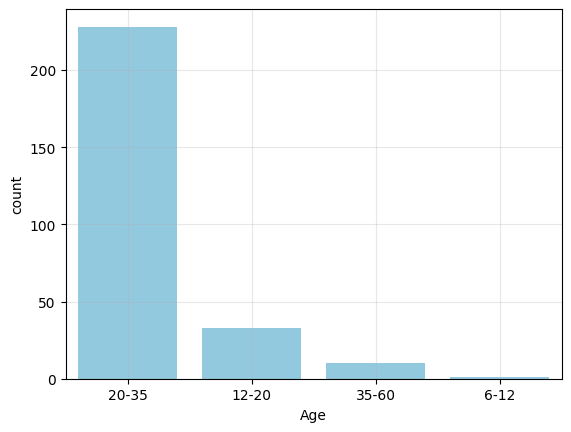

In [132]:
sns.countplot(x = 'Age',
              data = dfd_age,
              order = dfd_age['Age'].value_counts().index, color = 'skyblue')
plt.grid(True, alpha=0.3);

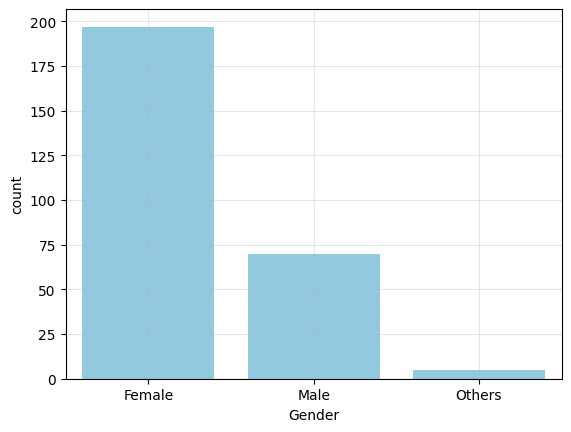

In [133]:
sns.countplot(x = 'Gender',
              data = dfd_gender,
              order = dfd_gender['Gender'].value_counts().index, color = 'skyblue')
plt.grid(True, alpha=0.3);

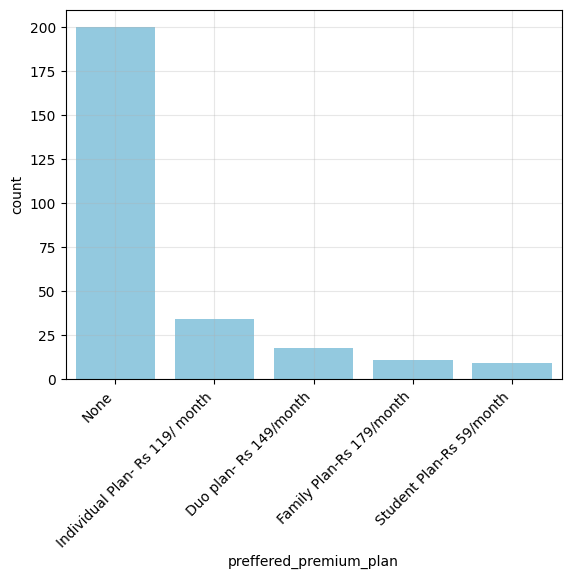

In [134]:
sns.countplot(x = 'preffered_premium_plan',
              data = dfd_premium,
              order = dfd_premium['preffered_premium_plan'].value_counts().index, color = 'skyblue')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3);

In [135]:
df_grpd_age_short = df_descriptive.groupby(by=['short_preffered_premium', 'Age']).size().reset_index(name = 'count')

In [136]:
df_grpd_age_short.columns = df_grpd_age_short.columns.str.lower()

In [137]:
df_grpd_age_short['short_preffered_premium'] = df_grpd_age_short['short_preffered_premium'].str.lower()

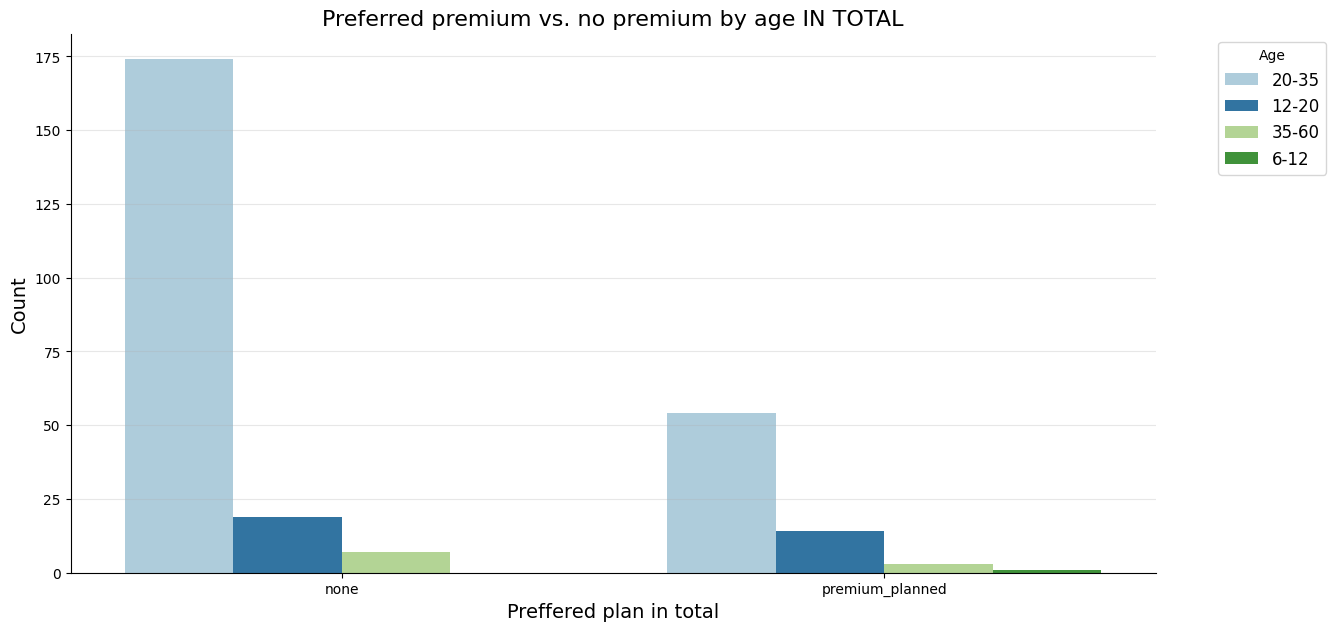

In [138]:
plt.figure(figsize=(14, 7))

df_grpd_age_short_sorted = df_grpd_age_short.sort_values(by='count', ascending=False)

ax = sns.barplot(x='short_preffered_premium', y='count', hue='age', data=df_grpd_age_short_sorted, palette = 'Paired')

plt.title('Preferred premium vs. no premium by age IN TOTAL', fontsize=16)

plt.xlabel('Preffered plan in total', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Age', fontsize=12)

sns.despine(left=False, right=True, top=True, bottom=False)

plt.grid(True, axis='y', alpha=0.3)

In [139]:
df_grpd_age = df_descriptive.groupby(by=['preffered_premium_plan', 'Age']).size().reset_index(name = 'count')

In [140]:
df_grpd_age.columns = df_grpd_age.columns.str.lower()

In [141]:
df_grpd_age['preffered_premium_plan'] = df_grpd_age['preffered_premium_plan'].str.lower()

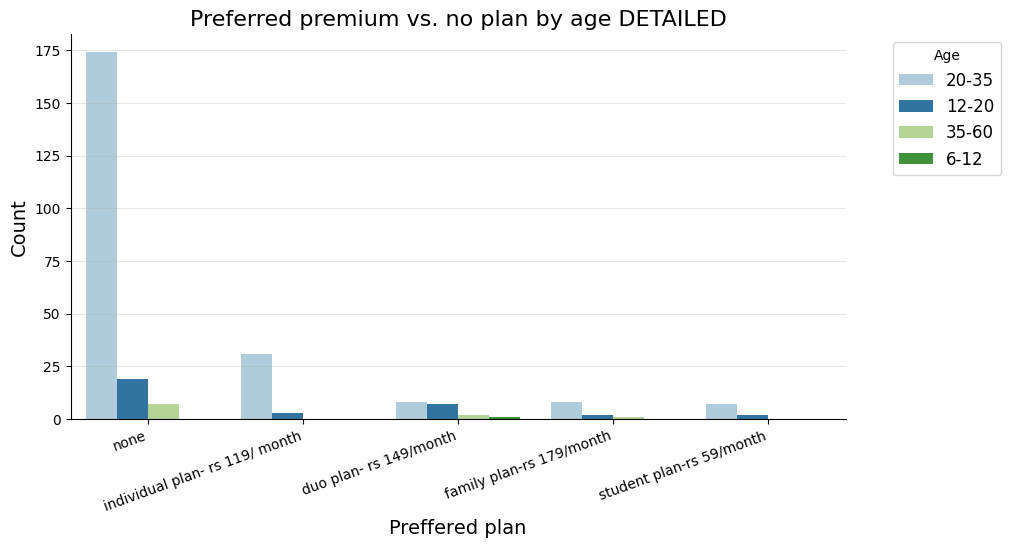

In [142]:
plt.figure(figsize=(10, 5))

df_grpd_age_sorted = df_grpd_age.sort_values(by='count', ascending=False)

sns.barplot(x='preffered_premium_plan', y='count', hue='age', data=df_grpd_age_sorted, palette = 'Paired')

plt.title('Preferred premium vs. no plan by age DETAILED', fontsize=16)

plt.xlabel('Preffered plan', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Age', fontsize=12)

sns.despine(left=False, right=True, top=True, bottom=False)

plt.xticks(rotation=20, ha='right')

plt.grid(True, axis='y', alpha=0.3)

Text(0.5, 1.0, 'Music rating by gender')

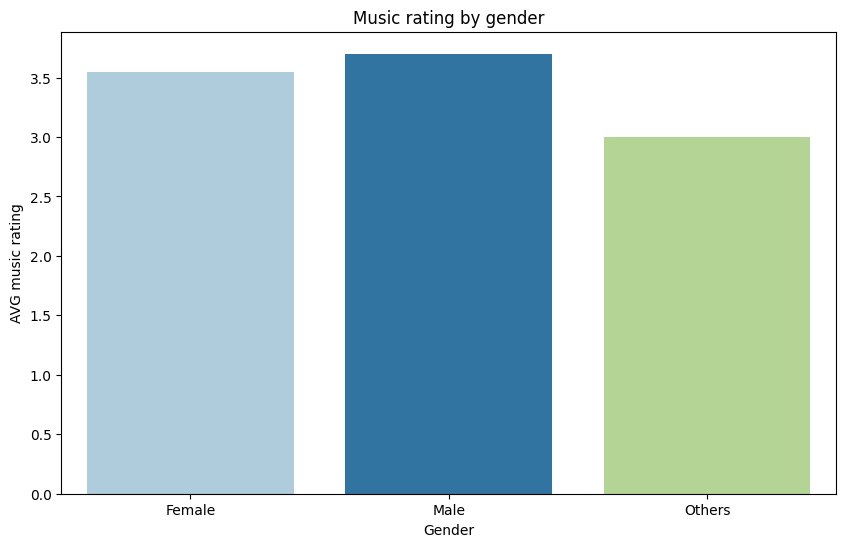

In [143]:
mean_rating = df_descriptive.groupby('Gender')['music_recc_rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='music_recc_rating', data=mean_rating,  hue='Gender',  palette = 'Paired')

plt.xlabel('Gender')
plt.ylabel('AVG music rating')
plt.title('Music rating by gender')

In [144]:
# To verify if the values match in the next steps

df.corr(method = 'kendall')

,age,spotify_usage_period,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,music_recc_rating,pod_lis_frequency,pod_variety_satisfaction,gender_female,...,pod_format_educational,pod_format_interview,pod_format_story,pod_host_pref_both,pod_host_pref_knowns,pod_host_pref_miss_data,pod_host_pref_unknowns,pref_pod_dur_both,pref_pod_dur_longer,pref_pod_dur_shorter
age,1.000000,-0.011139,-0.123115,-0.134301,-0.123115,-0.209317,0.170835,-0.060563,0.070516,0.013308,...,0.050016,-0.088716,0.047884,-0.102777,0.121195,0.039841,-0.068237,-0.123877,-0.152809,0.212152
spotify_usage_period,-0.011139,1.000000,0.116565,0.149657,0.098877,-0.103815,0.104271,-0.013759,0.075188,-0.099879,...,-0.013953,-0.030984,0.021036,0.085700,0.062861,-0.078762,-0.117512,0.026210,-0.102341,0.048428
spotify_subscription_plan,-0.123115,0.116565,1.000000,0.963546,0.944238,0.351769,-0.143413,0.192898,0.207067,-0.077333,...,-0.037274,0.014108,0.096835,0.113894,-0.062646,-0.243618,0.283433,0.140094,0.401663,-0.398497
premium_sub_willingness,-0.134301,0.149657,0.963546,1.000000,0.909817,0.331077,-0.137306,0.187240,0.212956,-0.092482,...,-0.028795,-0.000330,0.068817,0.119135,-0.041534,-0.259936,0.268479,0.162511,0.382952,-0.404763
preffered_premium_plan,-0.123115,0.098877,0.944238,0.909817,1.000000,0.349518,-0.147824,0.199572,0.187314,-0.060074,...,-0.042030,0.032590,0.086520,0.090192,-0.056914,-0.236609,0.304550,0.148237,0.388424,-0.396309
preferred_listening_content,-0.209317,-0.103815,0.351769,0.331077,0.349518,1.000000,-0.240412,0.420319,0.093888,-0.006939,...,-0.118288,0.100220,0.038235,0.038235,-0.022829,-0.280933,0.412906,0.242619,0.444077,-0.515838
music_recc_rating,0.170835,0.104271,-0.143413,-0.137306,-0.147824,-0.240412,1.000000,0.020014,0.278539,-0.049602,...,-0.005803,-0.051723,0.038442,0.029832,0.095266,-0.023003,-0.158224,-0.003990,-0.182052,0.129567
pod_lis_frequency,-0.060563,-0.013759,0.192898,0.187240,0.199572,0.420319,0.020014,1.000000,0.340334,0.047634,...,-0.087050,0.041979,-0.009076,0.282017,0.105402,-0.562929,0.246364,0.242666,0.304368,-0.419074
pod_variety_satisfaction,0.070516,0.075188,0.207067,0.212956,0.187314,0.093888,0.278539,0.340334,1.000000,-0.065391,...,-0.074085,0.043384,-0.016905,0.133526,0.202516,-0.347259,0.014904,0.034503,0.220377,-0.182300
gender_female,0.013308,-0.099879,-0.077333,-0.092482,-0.060074,-0.006939,-0.049602,0.047634,-0.065391,1.000000,...,-0.086409,-0.048334,0.042165,0.042165,-0.001489,-0.074147,0.046920,-0.126021,-0.030040,0.128924


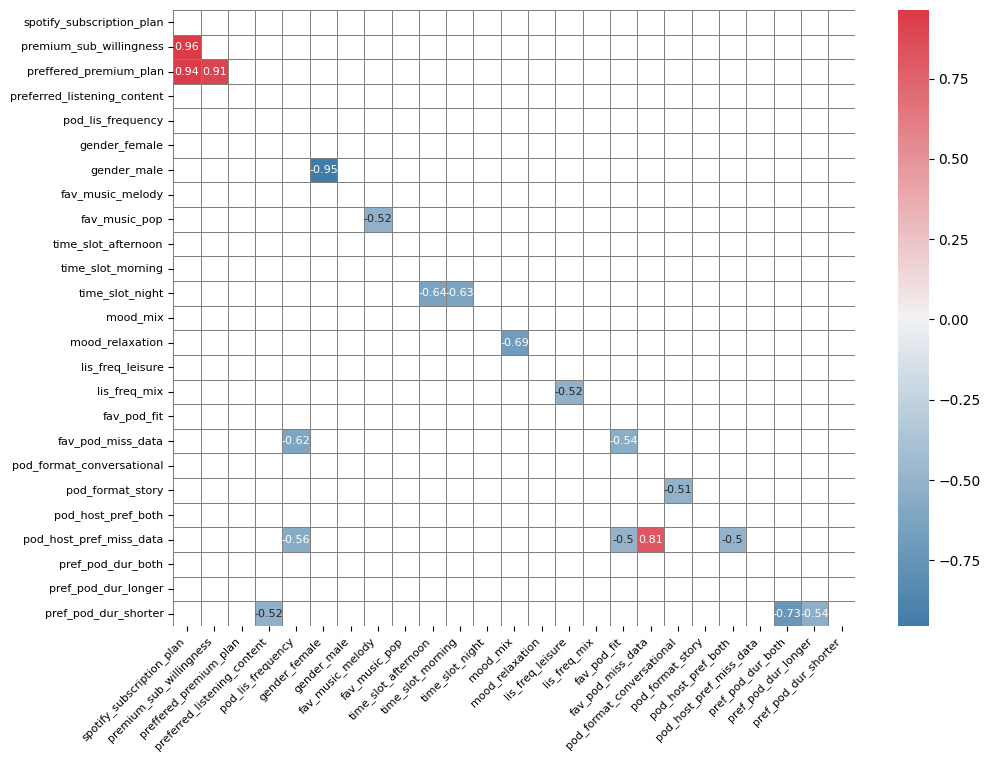

In [145]:
dfCorr = df.corr(method='kendall')
filteredDf = dfCorr[((dfCorr >= 0.5) | (dfCorr <= -0.5)) & (dfCorr != 1.0)]  

# filteredDf.loc['premium_sub_willingness', 'spotify_subscription_plan'] = dfCorr.loc['premium_sub_willingness', 'spotify_subscription_plan']

filteredDf = filteredDf.dropna(axis=0, how='all').dropna(axis=1, how='all')

mask = np.triu(np.ones_like(filteredDf, dtype=bool))

cmap = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(11, 8))
sns.heatmap(filteredDf, annot=True, cmap=cmap, mask=mask, annot_kws={"size": 8}, linecolor='gray', linewidths=0.5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(rotation=45, ha='right');

In [146]:
positive_correlations = []

for i in range(len(dfCorr.columns)):
    for j in range(i+1, len(dfCorr.columns)):
        correlation = dfCorr.iloc[i, j]
        if correlation > 0.5 and i != j:  
            variable1 = dfCorr.columns[i]
            variable2 = dfCorr.columns[j]
            
            corr, p_value = kendalltau(df[variable1], df[variable2])

            positive_correlations.append((variable1, variable2, correlation, p_value))

print("Positive Kendall Correlations\n")
print("=" * 80)

for pair in positive_correlations:
    variable1, variable2, correlation, p_value = pair
    
    print(f"\n{variable1}  VS  {variable2}")
    print('..' * 40)
    print(f"corr: {correlation}")
    print(f"p-value: {p_value}\n")
    print("=" * 80)


Positive Kendall Correlations


spotify_subscription_plan  VS  premium_sub_willingness
................................................................................
corr: 0.9635460822563594
p-value: 1.161905101516787e-56


spotify_subscription_plan  VS  preffered_premium_plan
................................................................................
corr: 0.9442381375112052
p-value: 2.7019149007157755e-59


premium_sub_willingness  VS  preffered_premium_plan
................................................................................
corr: 0.9098169581159634
p-value: 3.516809324549218e-55


fav_pod_miss_data  VS  pod_host_pref_miss_data
................................................................................
corr: 0.8128700732886767
p-value: 7.753446445691577e-41



In [147]:
negative = dfCorr.unstack().sort_values().drop_duplicates()
negative = negative[negative < -0.5]

In [148]:
print('Negative Kendall Correlations\n')
print('==' * 40)

for (variable1, variable2), correlation in negative.items():
    corr, p_value = kendalltau(df[variable1], df[variable2])

    print(f"\n{variable1}  VS  {variable2}")
    print('..' * 40)
    print(f"corr: {corr}")
    print(f"p-value: {p_value}\n")
    print('==' * 40)

Negative Kendall Correlations


gender_male  VS  gender_female
................................................................................
corr: -0.9540602827401999
p-value: 1.3799406245548006e-55


pref_pod_dur_both  VS  pref_pod_dur_shorter
................................................................................
corr: -0.7319406706116952
p-value: 1.9568908700463594e-33


mood_relaxation  VS  mood_mix
................................................................................
corr: -0.6892059382530715
p-value: 7.784544727348154e-30


time_slot_night  VS  time_slot_afternoon
................................................................................
corr: -0.6362726967786324
p-value: 1.1328876107702873e-25


time_slot_night  VS  time_slot_morning
................................................................................
corr: -0.6279309935202465
p-value: 4.790639686551872e-25


pod_lis_frequency  VS  fav_pod_miss_data
.......................................

# Machine learning

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [150]:
X = df.drop('premium_sub_willingness',axis=1)
y = df['premium_sub_willingness']

In [151]:
vars_to_drop = ['preffered_premium_plan', 'spotify_subscription_plan', 'fav_pod_miss_data', 
                'gender_male', 'gender_others']
X.drop(columns=vars_to_drop, inplace=True)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 99)

In [153]:
# After visualizations (charts in the attachment), it was decided to remove the age group 6-12; 
# it contains only one observation. The variables highly correlated with each other were also removed.

In [154]:
y_train.value_counts(normalize=True)

premium_sub_willingness
0    0.730061
1    0.269939
Name: proportion, dtype: float64

In [155]:
from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=3)

In [156]:
rfe_fit = rfe.fit(X_train, y_train)

In [157]:
rfe_fit.support_

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [158]:
features = X_train.columns[rfe_fit.support_]

In [159]:
features

Index(['fav_music_melody', 'mood_sad', 'pref_pod_dur_shorter'], dtype='object')

In [160]:
X_train = X_train[features]

In [161]:
X_test = X_test[features]

In [162]:
import imblearn

In [163]:
from imblearn.over_sampling import RandomOverSampler

In [164]:
ros = RandomOverSampler(random_state=0, sampling_strategy=0.4)

In [165]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [166]:
y_resampled.value_counts(normalize=True)

premium_sub_willingness
0    0.716867
1    0.283133
Name: proportion, dtype: float64

In [167]:
y_train.value_counts(normalize=True)

premium_sub_willingness
0    0.730061
1    0.269939
Name: proportion, dtype: float64

In [168]:
y_resampled.value_counts()

premium_sub_willingness
0    119
1     47
Name: count, dtype: int64

In [169]:
lr1 = LogisticRegression(max_iter=1000, random_state=123)

In [170]:
lr1.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, random_state=123)

In [171]:
y_pred = lr1.predict(X_test)

In [172]:
y_pred_train = lr1.predict(X_train)

In [173]:
from sklearn.metrics import confusion_matrix

In [174]:
confMatrix=confusion_matrix(y_test, y_pred)

In [175]:
confMatrix=pd.DataFrame(confMatrix)
confMatrix.columns=[['Predicted 0','Predicted 1']]
confMatrix.index=[['True 0','True 1']]
print('')
print('Confusion Matrix :')
print(confMatrix)


Confusion Matrix :
       Predicted 0 Predicted 1
True 0          65          12
True 1          16          16


In [176]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_auc_score

In [177]:
lr_accuracy = accuracy_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)

In [178]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        77
           1       0.57      0.50      0.53        32

    accuracy                           0.74       109
   macro avg       0.69      0.67      0.68       109
weighted avg       0.73      0.74      0.74       109



In [179]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       119
           1       0.82      0.52      0.64        44

    accuracy                           0.84       163
   macro avg       0.83      0.74      0.77       163
weighted avg       0.84      0.84      0.83       163



In [180]:
from sklearn import metrics

In [181]:
y_pred_proba = lr1.predict_proba(X_test)[:,1]

In [182]:
y_pred_proba

array([0.32546382, 0.26774407, 0.67219882, 0.26774407, 0.07921803,
       0.32546382, 0.07921803, 0.67219882, 0.07921803, 0.07921803,
       0.07921803, 0.26774407, 0.07921803, 0.67219882, 0.67219882,
       0.07921803, 0.26774407, 0.26774407, 0.07921803, 0.67219882,
       0.67219882, 0.32546382, 0.07921803, 0.67219882, 0.26774407,
       0.26774407, 0.07921803, 0.26774407, 0.26774407, 0.89968729,
       0.07921803, 0.07921803, 0.26774407, 0.07921803, 0.07921803,
       0.26774407, 0.07921803, 0.07921803, 0.07921803, 0.67219882,
       0.26774407, 0.32546382, 0.67219882, 0.67219882, 0.32546382,
       0.67219882, 0.67219882, 0.07921803, 0.07921803, 0.27340572,
       0.67219882, 0.26774407, 0.07921803, 0.26774407, 0.07921803,
       0.07921803, 0.26774407, 0.67219882, 0.89968729, 0.07921803,
       0.07921803, 0.26774407, 0.07921803, 0.32546382, 0.07921803,
       0.07921803, 0.07921803, 0.07921803, 0.26774407, 0.67219882,
       0.32546382, 0.07921803, 0.07921803, 0.07921803, 0.67219

In [183]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

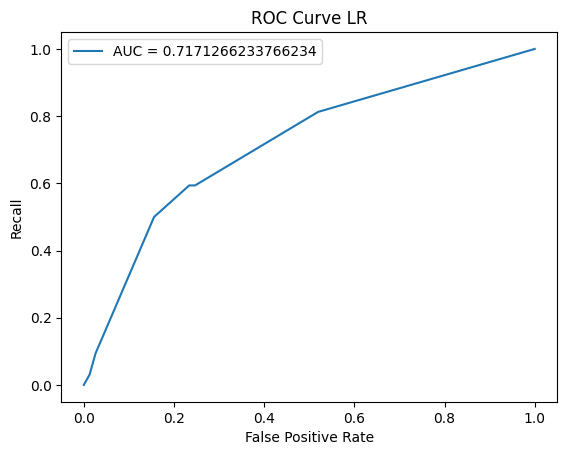

In [184]:
lr_auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC = "+str(lr_auc))
plt.title('ROC Curve LR')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [185]:
lr_auc

np.float64(0.7171266233766234)

In [186]:
y_pred_proba_train_res = lr1.predict_proba(X_resampled)[:,1]

In [187]:
lr1_auc_train = roc_auc_score(y_resampled, y_pred_proba_train_res)
lr1_auc_train

np.float64(0.8285356695869838)

In [188]:
y_pred_proba_train = lr1.predict_proba(X_train)[:,1]

In [189]:
lr1_auc_train = roc_auc_score(y_train, y_pred_proba_train)
lr1_auc_train

np.float64(0.8182773109243697)

In [190]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [191]:
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba)

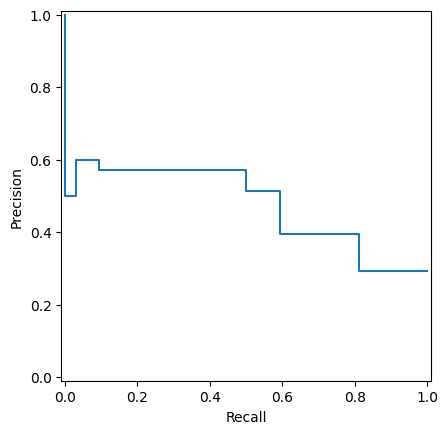

In [192]:
display = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
display.plot()

In [193]:
from sklearn.metrics import auc

In [194]:
PR_score_lr = auc(recall_lr, precision_lr)

In [195]:
PR_score_lr

np.float64(0.5088449639768446)

In [196]:
precision_recall_curve(y_test, y_pred_proba)[0][0:50]

array([0.29357798, 0.39393939, 0.5       , 0.51351351, 0.57142857,
       0.6       , 0.5       , 1.        ])

In [197]:
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)

In [198]:
auc(recall_train, precision_train)

np.float64(0.7343140091625342)

In [199]:
results1 = pd.DataFrame({
    'model': ['RL default'], 
    'accuracy': [lr_accuracy],
    'precision': [lr_precision],
    'recall': [lr_recall],
    'f1-score': [lr_f1],
    'auc': [lr_auc],
    'PR_score': [PR_score_lr]
    })

In [200]:
results1 

,model,accuracy,precision,recall,f1-score,auc,PR_score
0,RL default,0.743119,0.571429,0.5,0.533333,0.717127,0.508845


In [201]:
precision_train_r, recall_train_r, _ = precision_recall_curve(y_resampled, y_pred_proba_train_res)

In [202]:
auc(recall_train_r, precision_train_r)

np.float64(0.757765938885751)

In [203]:
from sklearn.model_selection import GridSearchCV

In [204]:
model = LogisticRegression(max_iter=1000, random_state=123)

In [205]:
params = {
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]
}

In [206]:
grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc')

In [207]:
grid_result = grid_search.fit(X_train, y_train)

In [208]:
grid_result = grid_search.fit(X_resampled, y_resampled)

In [209]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.825227 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [210]:
lr_opt = LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [211]:
lr_opt.fit(X_train,y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [212]:
y_pred = lr_opt.predict(X_test)

In [213]:
confMatrix=confusion_matrix(y_test, y_pred)

In [214]:
confMatrix=pd.DataFrame(confMatrix)
confMatrix.columns=[['Predicted 0','Predicted 1']]
confMatrix.index=[['True 0','True 1']]
print('')
print('Confusion Matrix :')
print(confMatrix)


Confusion Matrix :
       Predicted 0 Predicted 1
True 0          65          12
True 1          16          16


In [215]:
lr_opt_accuracy = accuracy_score(y_test, y_pred)
lr_opt_recall = recall_score(y_test, y_pred)
lr_opt_precision = precision_score(y_test, y_pred)
lr_opt_f1 = f1_score(y_test, y_pred)

In [216]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        77
           1       0.57      0.50      0.53        32

    accuracy                           0.74       109
   macro avg       0.69      0.67      0.68       109
weighted avg       0.73      0.74      0.74       109



In [217]:
y_pred_train = lr_opt.predict(X_train)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       119
           1       0.82      0.52      0.64        44

    accuracy                           0.84       163
   macro avg       0.83      0.74      0.77       163
weighted avg       0.84      0.84      0.83       163



In [218]:
import xgboost as xgb
from xgboost import XGBClassifier

In [219]:
X = df.drop('premium_sub_willingness',axis=1)
y = df['premium_sub_willingness']

In [220]:
vars_to_drop = ['preffered_premium_plan', 'spotify_subscription_plan', 'fav_pod_miss_data', 
                'gender_male', 'gender_others']
X.drop(columns=vars_to_drop, inplace=True)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 99)

In [222]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')

rfe = RFE(estimator=xgb, n_features_to_select=4)

rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

In [223]:
selected_features

Index(['fav_music_rap', 'mood_relaxation', 'mood_sad', 'pref_pod_dur_shorter'], dtype='object')

In [224]:
X_train = X_train[selected_features]

In [225]:
X_test = X_test[selected_features]

In [226]:
xgb = XGBClassifier(objective= 'binary:logistic', random_state=123)

In [227]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [228]:
y_pred = xgb.predict(X_test)

In [229]:
confMatrix=confusion_matrix(y_test, y_pred)

In [230]:
confMatrix=pd.DataFrame(confMatrix)
confMatrix.columns=[['Predicted 0','Predicted 1']]
confMatrix.index=[['True 0','True 1']]
print('')
print('Confusion Matrix :')
print(confMatrix)


Confusion Matrix :
       Predicted 0 Predicted 1
True 0          46          12
True 1          15           9


In [231]:
xgb_recall = recall_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred)

In [232]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77        58
           1       0.43      0.38      0.40        24

    accuracy                           0.67        82
   macro avg       0.59      0.58      0.59        82
weighted avg       0.66      0.67      0.66        82



In [233]:
y_pred_train = xgb.predict(X_train)

In [234]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       138
           1       0.71      0.65      0.68        52

    accuracy                           0.83       190
   macro avg       0.79      0.78      0.78       190
weighted avg       0.83      0.83      0.83       190



In [235]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')

rfe = RFE(estimator=xgb, n_features_to_select=19)

rfe.fit(X, y)

selected_features = X.columns[rfe.support_]

In [236]:
X = X[selected_features]

In [237]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')

params = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(estimator=xgb,
                                   param_distributions=params,
                                   cv=5, 
                                   n_iter=100, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   random_state=42)

from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

base_model = XGBClassifier()

bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores_bagging = cross_validate(bagging_model, X, y, scoring=scoring, cv=5, n_jobs=-1)

for metric in scoring:
    print(f"Mean {metric}: {np.mean(scores_bagging['test_' + metric]):.5f}")
random_search.fit(X, y)

print("Best parameters found: ", random_search.best_params_)

Mean accuracy: 0.77993
Mean precision: 0.62165
Mean recall: 0.58333
Mean f1: 0.56889
Mean roc_auc: 0.78706
Best parameters found:  {'colsample_bytree': np.float64(0.6185801650879991), 'gamma': np.float64(0.3037724259507192), 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 67, 'reg_alpha': 1, 'subsample': np.float64(0.9768807022739411)}


In [238]:
from sklearn.model_selection import cross_validate

scores_xgb_opt = cross_validate(xgb,
                                X,
                                y,
                                scoring=['precision', 'recall', 'accuracy', 'roc_auc', 'f1'],
                                cv=5,
                                n_jobs=-1)

In [239]:
results2 = pd.DataFrame({
    'model': ['XGB cross-val'], 
    'accuracy': [scores_xgb_opt['test_accuracy'].mean()],
    'precision': [scores_xgb_opt['test_precision'].mean()],
    'recall': [scores_xgb_opt['test_recall'].mean()],
    'f1-score': [scores_xgb_opt['test_f1'].mean()],
    'auc': [scores_xgb_opt['test_roc_auc'].mean()]
    })

In [240]:
results2

,model,accuracy,precision,recall,f1-score,auc
0,XGB cross-val,0.761279,0.598726,0.5825,0.558812,0.776726


In [241]:
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

base_model = XGBClassifier()

bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores_bagging = cross_validate(bagging_model, X, y, scoring=scoring, cv=5, n_jobs=-1)

for metric in scoring:
    print(f"Mean {metric}: {np.mean(scores_bagging['test_' + metric]):.5f}")

Mean accuracy: 0.77993
Mean precision: 0.62165
Mean recall: 0.58333
Mean f1: 0.56889
Mean roc_auc: 0.78706


In [242]:
import pickle

In [243]:
%store df_descriptive

Stored 'df_descriptive' (DataFrame)


/home/sabalunax/anaconda3/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/df_descriptive requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [244]:
%store df_grpd_age_short_sorted

Stored 'df_grpd_age_short_sorted' (DataFrame)


/home/sabalunax/anaconda3/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/df_grpd_age_short_sorted requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [245]:
%store X

Stored 'X' (DataFrame)


/home/sabalunax/anaconda3/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/X requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [246]:
%store y

Stored 'y' (Series)


/home/sabalunax/anaconda3/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/y requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [247]:
#engine = create_engine('postgresql+psycopg2:// xxx : xxx @ xxx: xxx/xxx')

In [248]:
#df.to_sql('spotify', engine, if_exists='replace', index=False)